<a href="https://colab.research.google.com/github/Fu-Pei-Yin/Deep-Generative-Mode/blob/week2/Diffusion_Model%E5%9C%A8%E6%89%8B%E5%AF%AB%E6%95%B8%E5%AD%97%E4%B8%8A%E7%9A%84%E6%87%89%E7%94%A8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Training DDPM on MNIST...


Epoch 1/80: 100%|██████████| 469/469 [00:27<00:00, 17.14it/s, loss=0.0333]


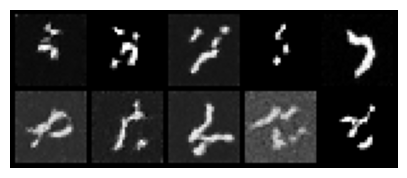

Epoch 2/80: 100%|██████████| 469/469 [00:27<00:00, 17.27it/s, loss=0.0317]


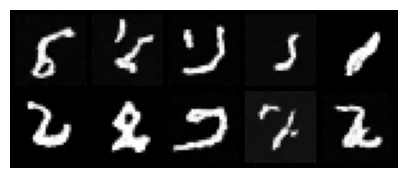

Epoch 3/80: 100%|██████████| 469/469 [00:27<00:00, 17.36it/s, loss=0.0286]


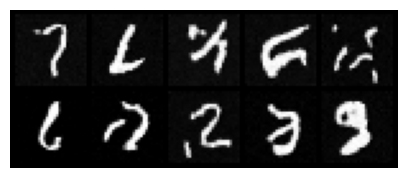

Epoch 4/80: 100%|██████████| 469/469 [00:27<00:00, 17.21it/s, loss=0.0239]


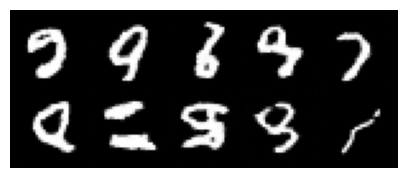

Epoch 5/80: 100%|██████████| 469/469 [00:27<00:00, 17.12it/s, loss=0.0267]


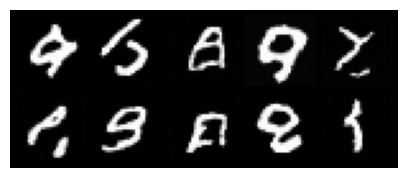

Epoch 6/80: 100%|██████████| 469/469 [00:27<00:00, 17.18it/s, loss=0.0274]


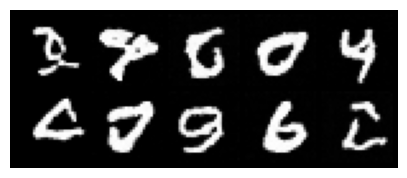

Epoch 7/80:  80%|████████  | 377/469 [00:22<00:05, 17.56it/s, loss=0.0277]

In [ ]:
# ddpm_mnist.py
# DDPM (simplified) for MNIST — PyTorch, Colab-ready
# With posterior_variance fix

import os
import math
import random
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms, utils

# -------------------------
# Settings
# -------------------------
seed = 42
batch_size = 128
image_size = 28
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epochs = 80
lr = 2e-4
timesteps = 1000
out_dir = "ddpm_out"
os.makedirs(out_dir, exist_ok=True)

# -------------------------
# Reproducibility
# -------------------------
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

# -------------------------
# Data (MNIST)
# -------------------------
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),           # [0,1]
    transforms.Normalize((0.5,), (0.5,))  # [-1,1]
])

train_ds = torchvision.datasets.MNIST(root="./data", train=True, download=True, transform=transform)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

# -------------------------
# Diffusion Utilities
# -------------------------
def linear_beta_schedule(timesteps):
    beta_start = 1e-4
    beta_end = 0.02
    return torch.linspace(beta_start, beta_end, timesteps)

betas = linear_beta_schedule(timesteps).to(device)  # (T,)
alphas = 1.0 - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - alphas_cumprod)

# ✅ 修正 posterior_variance
posterior_variance = betas * (1.0 - torch.cat([torch.tensor([1.0], device=device), alphas_cumprod[:-1]])) \
                     / (1.0 - alphas_cumprod).clamp(min=1e-20)

# extract helper
def extract(a, t, x_shape):
    b = t.shape[0]
    out = a.gather(-1, t).float().to(device)
    return out.view(b, *((1,) * (len(x_shape) - 1)))

# q_sample: produce x_t from x_0
def q_sample(x_start, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_start)
    return extract(sqrt_alphas_cumprod, t, x_start.shape) * x_start + \
           extract(sqrt_one_minus_alphas_cumprod, t, x_start.shape) * noise

# -------------------------
# Model: small U-Net
# -------------------------
class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
    def forward(self, t):
        device = t.device
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = t[:, None] * emb[None, :]
        return torch.cat([torch.sin(emb), torch.cos(emb)], dim=-1)

class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.GroupNorm(8, out_ch),
            nn.SiLU(),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.GroupNorm(8, out_ch),
            nn.SiLU(),
        )
    def forward(self, x):
        return self.net(x)

class UNetSmall(nn.Module):
    def __init__(self, in_channels=1, base_ch=64, time_emb_dim=128):
        super().__init__()
        self.time_mlp = nn.Sequential(
            SinusoidalPosEmb(time_emb_dim//2),
            nn.Linear(time_emb_dim//2, time_emb_dim),
            nn.SiLU(),
            nn.Linear(time_emb_dim, time_emb_dim),
        )
        self.conv1 = DoubleConv(in_channels, base_ch)
        self.down1 = nn.Conv2d(base_ch, base_ch*2, 4, stride=2, padding=1)
        self.conv2 = DoubleConv(base_ch*2, base_ch*2)
        self.mid = DoubleConv(base_ch*2, base_ch*2)
        self.up1 = nn.ConvTranspose2d(base_ch*2, base_ch, 4, stride=2, padding=1)
        self.conv3 = DoubleConv(base_ch*2, base_ch)
        self.out = nn.Conv2d(base_ch, in_channels, 1)
        self.time_proj = nn.Sequential(nn.SiLU(), nn.Linear(time_emb_dim, base_ch*2))

    def forward(self, x, t):
        B = x.shape[0]
        temb = self.time_mlp(t.float()[:, None])
        c1 = self.conv1(x)
        d1 = self.conv2(self.down1(c1))
        mid = self.mid(d1)
        mid = mid + self.time_proj(temb).view(B, -1, 1, 1)
        up = self.up1(mid)
        cat = torch.cat([up, c1], dim=1)
        out = self.conv3(cat)
        return self.out(out)

model = UNetSmall().to(device)

# -------------------------
# Optimizer + Loss
# -------------------------
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
mse = nn.MSELoss()

# -------------------------
# Training
# -------------------------
def train():
    model.train()
    for epoch in range(1, epochs + 1):
        pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{epochs}")
        for imgs, _ in pbar:
            imgs = imgs.to(device)
            bs = imgs.shape[0]
            t = torch.randint(0, timesteps, (bs,), device=device).long()
            noise = torch.randn_like(imgs)
            x_t = q_sample(imgs, t, noise=noise)
            pred_noise = model(x_t, t)
            loss = mse(pred_noise, noise)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            pbar.set_postfix({"loss": loss.item()})
        sample_and_save(epoch)

# -------------------------
# Sampling
# -------------------------
@torch.no_grad()
def p_sample_loop(model, shape, device):
    img = torch.randn(shape, device=device)
    for i in reversed(range(timesteps)):
        t = torch.full((shape[0],), i, device=device, dtype=torch.long)
        pred_noise = model(img, t)
        alpha_t = alphas[i]
        alpha_cumprod_t = alphas_cumprod[i]
        beta_t = betas[i]
        coef1 = 1 / math.sqrt(alpha_t)
        coef2 = beta_t / math.sqrt(1 - alpha_cumprod_t)
        mean = coef1 * (img - coef2 * pred_noise)
        if i > 0:
            var = betas[i]
            img = mean + torch.sqrt(var) * torch.randn_like(img)
        else:
            img = mean
    return img

@torch.no_grad()
def sample_and_save(epoch):
    model.eval()
    samples = p_sample_loop(model, (10, 1, image_size, image_size), device)
    samples = (samples.clamp(-1, 1) + 1) / 2.0
    grid = utils.make_grid(samples, nrow=5, padding=2)
    utils.save_image(grid, f"{out_dir}/samples_epoch_{epoch}.png")
    plt.figure(figsize=(5,5))
    plt.axis("off")
    plt.imshow(grid.permute(1,2,0).cpu().numpy().squeeze(), cmap="gray")
    plt.show()

# -------------------------
# Main
# -------------------------
if __name__ == "__main__":
    print("Training DDPM on MNIST...")
    train()
    sample_and_save("final")
    print("Done. Check ddpm_out/ for results.")
